This Notebook presents an attempt to build a model that learns image segmentation using convolutional neural networks ,by building a very simple model .


1.   The dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.[link text](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation)
      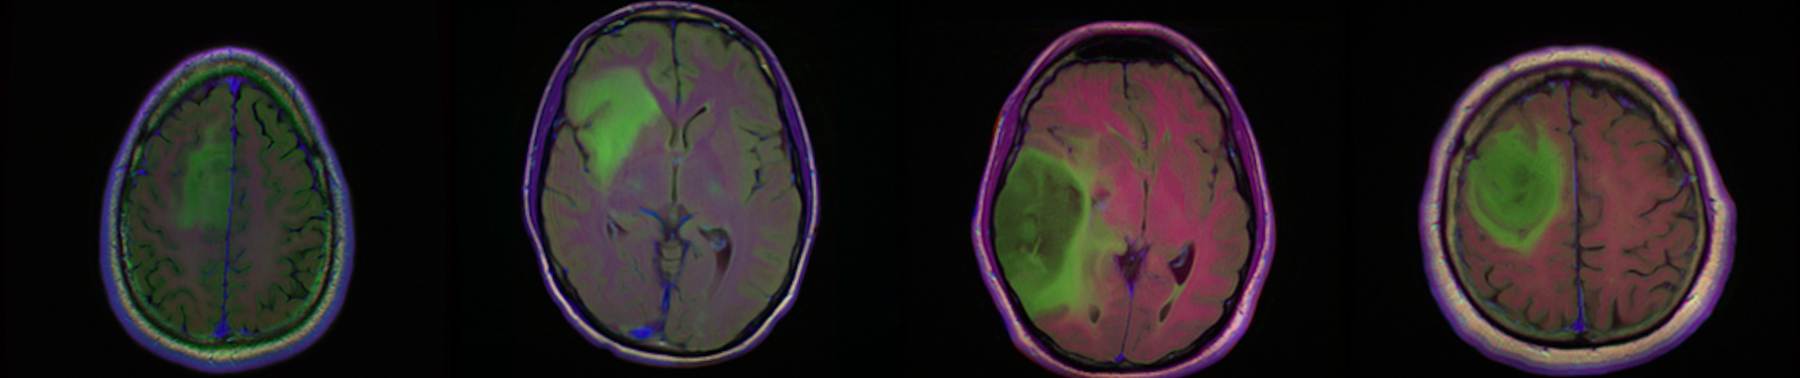  



In [1]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bahriaymen","key":"a13346c4c42326125bedf0153e4a7d20"}'}

In [3]:
import tensorflow as tf 
tf.__version__ #!pip install tensorflow==2.9.2 data augmentation issue on 2.11 when using randomflip 

'2.11.0'

In [ ]:
#!pip install tensorflow==2.9.2 

In [4]:
#create kaggle hidden dir and copy the json file to it 
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
#download data 
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

100% 712M/714M [00:34<00:00, 24.8MB/s]
100% 714M/714M [00:34<00:00, 21.5MB/s]


In [6]:
!unzip -qq lgg-mri-segmentation.zip

### we end up with a directory of subdirectories ,each one of them contains images and their masks ,what need to be done next is to regroupe paths to masks and input images separately in two lists that I will simply call targets and input_img_paths ,this step is needed later when spliting the data into batches ,where I'll define a BatchGenerator class that provides me with targets and input_imgs as batches of data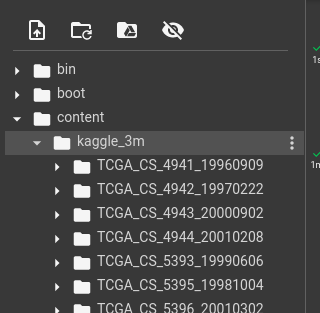

In [7]:
import os
input_dir = "kaggle_3m/" #input directory 
sub_dirs_paths = [os.path.join(input_dir,sub_dir) for sub_dir in os.listdir(input_dir) if not(sub_dir.endswith(".md") or sub_dir.endswith(".csv"))]#holds  paths to subdirectories

input_img_paths = []     
targets = []
#loop over subdirectories ,inside each subdir,if the name contains (mask.tif) put its path  into targets otherwise into input_imgs_paths
for path in sub_dirs_paths:            
  for fname in os.listdir(path):
    if fname.endswith("mask.tif"):
      targets.append(os.path.join(path,fname))
    else:
      input_img_paths.append(os.path.join(path,fname))



In [8]:
#sort input_imgs and targets
input_img_paths.sort()
targets.sort()

In [9]:
#check the first few paths  
for i in range(5):
  print(input_img_paths[i],"\t",targets[i])

kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif
kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif
kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif
kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif
kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14_mask.tif


its clear that even with sort the files  doesn't correspond one to another so I need to sort them manually ,for each name in the input_img_paths ,I search for the exact mask corresponding to it and place it at the same index 

In [10]:
#sort  targets  by extracting names from input images  and comparing them to masks ,
new_targets = []
for path in input_img_paths:
  for target in targets:
    name = path.split("/")[-1].split(".")[0]
    mask_name = "_".join(target.split("/")[-1].split("_")[:-1])
    if(name == mask_name):
      new_targets.append(target)



In [11]:
#check again
for i in range(5):
  print(input_img_paths[i],"\t",new_targets[i])

kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_mask.tif
kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif
kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif
kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif
kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif 	 kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif


In [12]:
#total number of  images 
len(new_targets)

3929

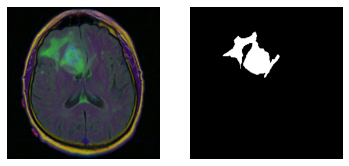

In [13]:
#visulaize and image and its mask 
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img,img_to_array

plt.subplot(1,2,1)
plt.axis("off")
plt.imshow(load_img(input_img_paths[5]))
plt.subplot(1,2,2)
plt.axis("off")
plt.imshow(load_img(new_targets[5]))

In [14]:
#check targets shape and range of values ,for resizing and normalization  
img_to_array(load_img(new_targets[4])).max(),img_to_array(load_img(new_targets[4])).shape #the mask is all zeros and 255 in the tumor region 

(255.0, (256, 256, 3))

since its a sort of binary classification problem ,i.e each pixel in the target mask will be either 255 or 0 its better to normalize all the targets to (0,1) range ,also I will try to create a batch generator that generates batch of data in each call ,this will be called in a fit function to provide the data,loss will be computed using tensorflow GradientTape

In [15]:
#creating a batch generator 
import math
from tensorflow.keras.utils import load_img,img_to_array
from tensorflow import keras
import numpy as np
import random

class BatchGenerator(keras.utils.Sequence):
    def __init__(self,input_paths,target_paths,img_size,batch_size = 32):                 
        self.input_paths= input_paths
        self.target_paths = target_paths                              #target images paths
        self.batch_size = batch_size
        self.img_size = img_size


    def path_to_input_image(self,path):
      """Returns the resized image from the specified path"""
      return img_to_array(load_img(path,target_size=self.img_size))

    def path_to_target(self,path):
      """Returns the resized and normalized  mask from the specified path"""
      img = img_to_array(load_img(path,target_size=self.img_size,color_mode="grayscale"))   #one channel only
      img = img/255                                                         #pixel values  either (0 or 1)
      return img.astype("uint8")
    
    def __len__(self):
        """ needed when calling fit ,returns number of batches"""
        return len(self.target_paths) // self.batch_size

    def __getitem__(self,index):
      """ returns a  batch """

      imgs = np.zeros((self.batch_size,)+self.img_size+(3,),dtype="float32")
      targets  =np.zeros((self.batch_size,)+self.img_size+(1,),dtype="uint8")
      for i in range(self.batch_size):
          imgs[i] = self.path_to_input_image(self.input_paths[index*self.batch_size+i])
          targets[i] = self.path_to_target(self.target_paths[index*self.batch_size+i])
      return imgs,targets


In [16]:
import random
random.Random(1337).shuffle(input_img_paths)                
random.Random(1337).shuffle(new_targets)

num_validation_samples = int(len(input_img_paths)*0.2)   #set 20% of data for validation 
train_images_paths = input_img_paths[:-num_validation_samples]
train_targets_paths = new_targets[:-num_validation_samples]
val_images_paths = input_img_paths[-num_validation_samples:]
val_targets_paths = new_targets[-num_validation_samples:]


In [17]:
from keras.api._v2.keras import activations
from tensorflow import keras
from tensorflow.keras import layers

#input a (200,200,3) image and get a (200,200,2) output with (0,1) classes
img_size = (200,200)
def get_model(img_size,num_classes):
  inputs = keras.Input(shape=img_size + (3,))
  x = layers.BatchNormalization()(inputs)

#downsampling layers
  x = layers.Conv2D(64,3,strides = 2,activation = "relu",padding="same")(x)  
  x = layers.Conv2D(64,3,activation = "relu",padding="same")(x)
  x = layers.Conv2D(128,3,activation = "relu",strides = 2,padding="same")(x)   
  x = layers.Conv2D(128,3,activation = "relu",padding="same")(x)


#upsampling layers
  x = layers.Conv2DTranspose(128,3,activation="relu",padding="same")(x)
  x = layers.Conv2DTranspose(128,3,strides = 2,activation="relu",padding="same")(x)
  x = layers.Conv2DTranspose(64,3,activation="relu",padding="same")(x)
  x = layers.Conv2DTranspose(64,3,strides = 2,activation="relu",padding="same")(x)

  outputs = layers.Conv2D(num_classes,3,activation="sigmoid",padding="same")(x)
  model = keras.Model(inputs,outputs)


  return model
#free up memory 
keras.backend.clear_session()

model = get_model(img_size,num_classes=2) #number of classes is 2 because it a sort of  binary problem where each pixel in the image will get a class (either 0 or 1)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                             

In [18]:
img_size = (200,200)
batch_size = 64
train_data = BatchGenerator(train_images_paths,train_targets_paths,img_size,batch_size)
val_data = BatchGenerator(val_images_paths,val_targets_paths,img_size,batch_size)

In [19]:
callback = [keras.callbacks.EarlyStopping(monitor="loss",patience = 2),keras.callbacks.ModelCheckpoint("MR_Brain_Tumor_segmentation.h5", save_best_only=True)]
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["accuracy"])#using binary_crossentropy as loss won't give any good results
histroy = model.fit(train_data,epochs=30,validation_data=val_data)

Epoch 1/30
49/49 [==============================] - 40s 479ms/step - loss: 0.0855 - accuracy: 0.9924 - val_loss: 0.0362 - val_accuracy: 1.0000
Epoch 2/30
49/49 [==============================] - 24s 480ms/step - loss: 0.0317 - accuracy: 0.9991 - val_loss: 0.0294 - val_accuracy: 0.9881
Epoch 3/30
49/49 [==============================] - 24s 483ms/step - loss: 0.0275 - accuracy: 0.9938 - val_loss: 0.0259 - val_accuracy: 0.9905
Epoch 4/30
49/49 [==============================] - 23s 475ms/step - loss: 0.0256 - accuracy: 0.9944 - val_loss: 0.0251 - val_accuracy: 0.9906
Epoch 5/30
49/49 [==============================] - 23s 474ms/step - loss: 0.0245 - accuracy: 0.9939 - val_loss: 0.0233 - val_accuracy: 0.9971
Epoch 6/30
49/49 [==============================] - 24s 478ms/step - loss: 0.0231 - accuracy: 0.9941 - val_loss: 0.0242 - val_accuracy: 0.9946
Epoch 7/30
49/49 [==============================] - 24s 478ms/step - loss: 0.0220 - accuracy: 0.9937 - val_loss: 0.0192 - val_accuracy: 0.9929

In [40]:
history = histroy.history

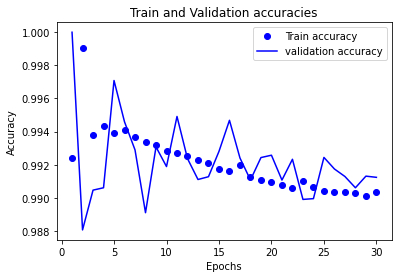

In [41]:

import matplotlib.pyplot as plt
train_acc =history["accuracy"]
val_acc = history["val_accuracy"]
epochs = range(1,len(train_acc) + 1)
plt.plot(epochs,train_acc,"bo",label = "Train accuracy")
plt.plot(epochs,val_acc,"b",label = "validation accuracy")
plt.title("Train and Validation accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [20]:
 #testing the model on some already seen data
from tensorflow.keras.utils import array_to_img,img_to_array,load_img

test_images_paths = input_img_paths[1000:1009]
test_masks_paths = new_targets[1000:1009]

1/1 [==============================] - 0s 20ms/step


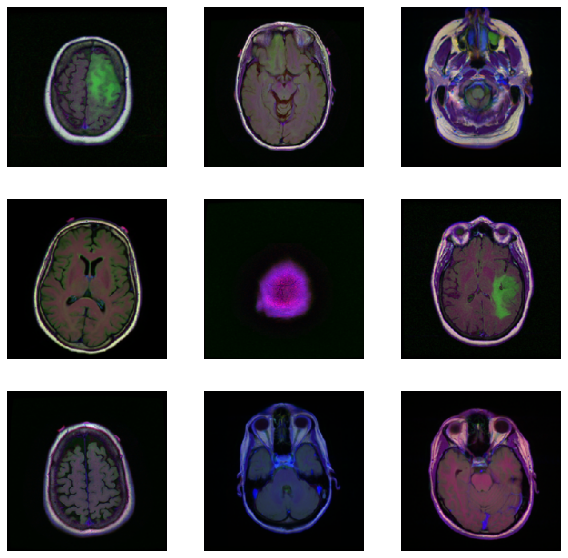

In [29]:
im_size = (200,200)
plt.figure(figsize=(10,10))
predictions = np.zeros((9,) + im_size+(2,))
for i in range(1,len(test_images_paths)+1):
  plot = plt.subplot(3,3,i)
  plt.axis("off")
  img = array_to_img(load_img(test_images_paths[i-1],target_size=im_size))
  predictions[i-1] = model.predict(np.expand_dims(img, 0))[0]
  plt.imshow(array_to_img(img))





1/1 [==============================] - 0s 30ms/step


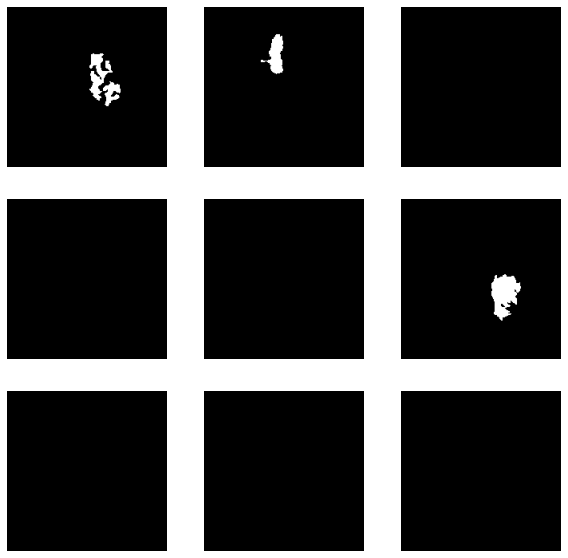

In [31]:
#true targets
im_size = (200,200)
plt.figure(figsize=(10,10))
for i in range(1,len(test_images_paths)+1):
  plot = plt.subplot(3,3,i)
  plt.axis("off")
  img = array_to_img(load_img(test_masks_paths[i-1],target_size=im_size))
  plt.imshow(array_to_img(img))


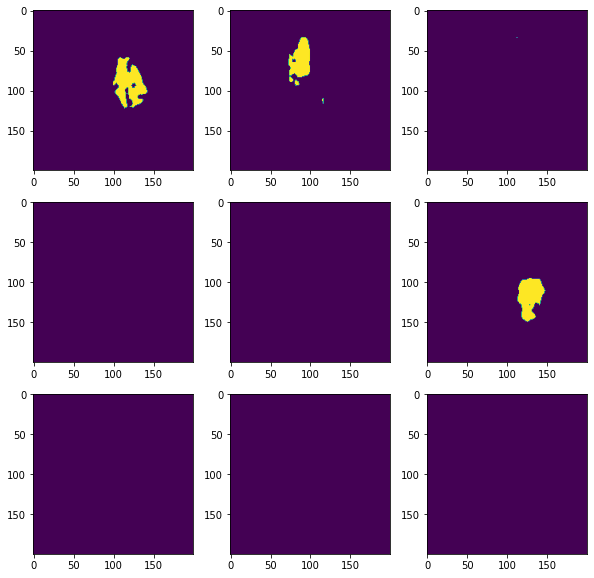

In [30]:
#Predictions
plt.figure(figsize=(10,10))
for i in range(9):
  mask = np.argmax(predictions[i], axis=-1)#build an array by extracting the max value from the channels build a single channel array
  mask *= 255
  plot = plt.subplot(3,3,i+1)
  plt.imshow(mask)


###fair enough

In [36]:
#predicting on unseen data 
test_images_paths = val_images_paths[200:209]
test_masks_paths = val_targets_paths[200:209]

1/1 [==============================] - 0s 21ms/step


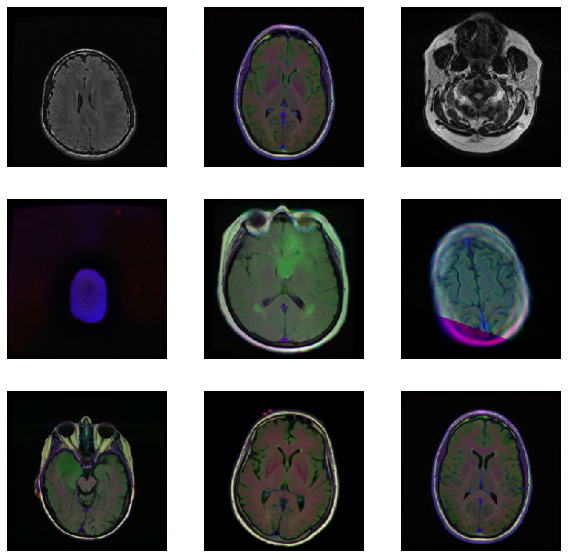

In [37]:
im_size = (200,200)
plt.figure(figsize=(10,10))
predictions = np.zeros((9,) + im_size+(2,))
for i in range(1,len(test_images_paths)+1):
  plot = plt.subplot(3,3,i)
  plt.axis("off")
  img = array_to_img(load_img(test_images_paths[i-1],target_size=im_size))
  predictions[i-1] = model.predict(np.expand_dims(img, 0))[0]
  plt.imshow(array_to_img(img))


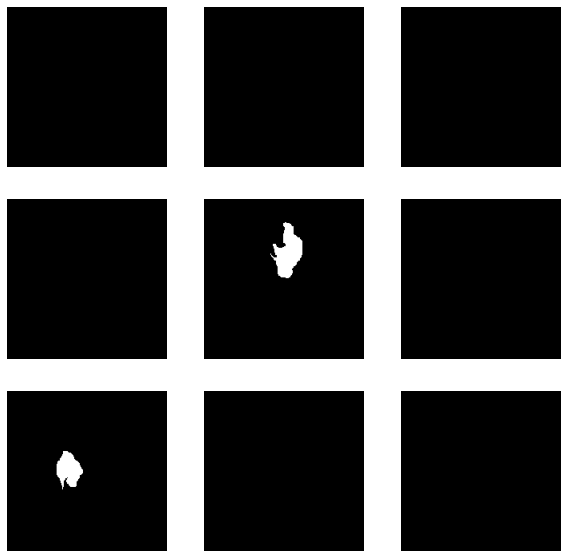

In [38]:
im_size = (200,200)
plt.figure(figsize=(10,10))
for i in range(1,len(test_images_paths)+1):
  plot = plt.subplot(3,3,i)
  plt.axis("off")
  img = array_to_img(load_img(test_masks_paths[i-1],target_size=im_size))
  plt.imshow(array_to_img(img))

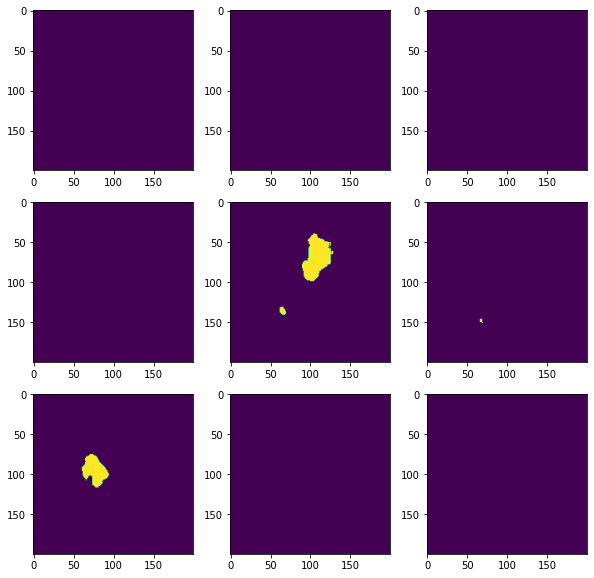

In [39]:
#Predictions
plt.figure(figsize=(10,10))
for i in range(9):
  mask = np.argmax(predictions[i], axis=-1)#build an array by extracting the max value from the channels build a single channel array
  mask *= 255
  plot = plt.subplot(3,3,i+1)
  plt.imshow(mask)

### seems pretty good for a very simple model 

prediction is not quit good even in a an already seen sample

###data augmentation ,since randomflip contains a bug I'll simply use np.flip with some random genrated axes that'll be uses to flip images virtically and horizontally 

> Indented block



In [43]:
import keras
import tensorflow as tf
class BatchGenerator(keras.utils.Sequence):
    def __init__(self,input_paths,target_paths,img_size,batch_size = 32,augmented = False):
        super().__init__()                 
        self.input_paths= input_paths
        self.target_paths = target_paths                              #target images paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.augmented = augmented


    def path_to_input_image(self,path):
      """Returns the resized image from the specified path"""
      return img_to_array(load_img(path,target_size=self.img_size))

    def path_to_target(self,path):
      """Returns the resized and normalized  mask from the specified path"""
      img = img_to_array(load_img(path,target_size=self.img_size,color_mode="grayscale"))   #one channel only
      img = img/255                                                         #pixel values  either (0 or 1)
      return img.astype("uint8")

    
    def __len__(self):
        """ needed when calling fit ,returns number of batches"""
        return len(self.target_paths) // self.batch_size

    def __getitem__(self,index):
      """ called by and indexed by fit ,returns a  batch """

      imgs = np.zeros((self.batch_size,)+self.img_size+(3,),dtype="float32")
      targets  =np.zeros((self.batch_size,)+self.img_size+(1,),dtype="uint8")
      for i in range(self.batch_size):
          imgs[i] = self.path_to_input_image(self.input_paths[index*self.batch_size+i])
          targets[i] = self.path_to_target(self.target_paths[index*self.batch_size+i])
      #horizontal  flip
      #due to a bug in RandomFlip ,its better to use just np.flip
      data_augmentation =np.flip  
      axis = random.randint(0,3)  #random number to either flip vertically or horizontally
      if not self.augmented or axis == 0:
        return imgs,targets
      elif self.augmented and (axis == 1 or axis == 2) :
        return data_augmentation(imgs,axis),data_augmentation(targets,axis) #horizontal or vertical flip 
      else:
        return data_augmentation(imgs,(1,2)),data_augmentation(targets,(1,2)) #horizontal vertical flip 




In [46]:
img_size = (200,200)
batch_size = 128
train_data = BatchGenerator(train_images_paths,train_targets_paths,img_size,batch_size,augmented = True)
val_data = BatchGenerator(val_images_paths,val_targets_paths,img_size,batch_size)

(-0.5, 199.5, 199.5, -0.5)

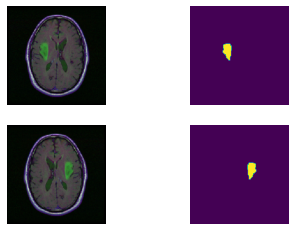

In [47]:
#see what calling train_data gives 
image_1,mask_1 = train_data[0]
image_2,mask_2 = train_data[0]
plt.subplot(2,2,1)
plt.axis("off")
plt.imshow(array_to_img(image_1[40]))
plt.subplot(2,2,2)
plt.imshow(array_to_img(mask_1[40]))
plt.axis("off")
plt.subplot(2,2,3)
plt.imshow(array_to_img(image_2[40]))
plt.axis("off")
plt.subplot(2,2,4)
plt.imshow(array_to_img(mask_2[40]))
plt.axis("off")




In [49]:
callback = [keras.callbacks.EarlyStopping(monitor="loss",patience = 3),keras.callbacks.ModelCheckpoint("MR_Brain_Tumor_segmentation.h5", save_best_only=True)]
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = model.fit(train_data,epochs=30,validation_data=val_data)

Epoch 1/30
24/24 [==============================] - 25s 943ms/step - loss: 0.0207 - accuracy: 0.9916 - val_loss: 0.0116 - val_accuracy: 0.9911
Epoch 2/30
24/24 [==============================] - 23s 955ms/step - loss: 0.0117 - accuracy: 0.9915 - val_loss: 0.0093 - val_accuracy: 0.9911
Epoch 3/30
24/24 [==============================] - 23s 972ms/step - loss: 0.0101 - accuracy: 0.9908 - val_loss: 0.0083 - val_accuracy: 0.9912
Epoch 4/30
24/24 [==============================] - 24s 981ms/step - loss: 0.0097 - accuracy: 0.9909 - val_loss: 0.0081 - val_accuracy: 0.9913
Epoch 5/30
24/24 [==============================] - 24s 970ms/step - loss: 0.0088 - accuracy: 0.9905 - val_loss: 0.0079 - val_accuracy: 0.9904
Epoch 6/30
24/24 [==============================] - 23s 969ms/step - loss: 0.0087 - accuracy: 0.9906 - val_loss: 0.0078 - val_accuracy: 0.9907
Epoch 7/30
24/24 [==============================] - 23s 961ms/step - loss: 0.0087 - accuracy: 0.9905 - val_loss: 0.0087 - val_accuracy: 0.9899

1/1 [==============================] - 0s 21ms/step


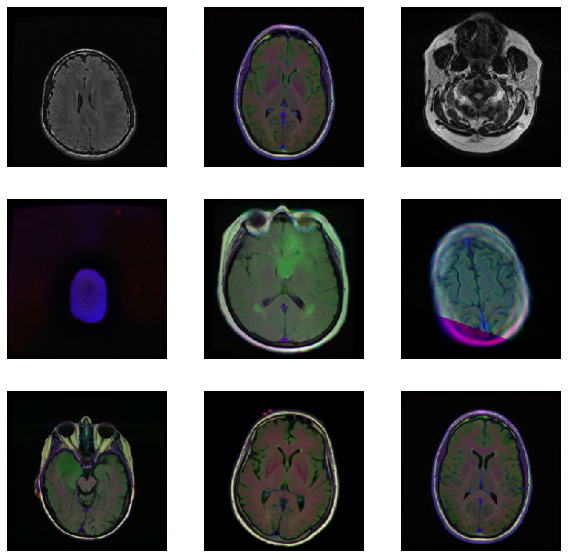

In [50]:
im_size = (200,200)
plt.figure(figsize=(10,10))
predictions = np.zeros((9,) + im_size+(2,))
for i in range(1,len(test_images_paths)+1):
  plot = plt.subplot(3,3,i)
  plt.axis("off")
  img = array_to_img(load_img(test_images_paths[i-1],target_size=im_size))
  predictions[i-1] = model.predict(np.expand_dims(img, 0))[0]
  plt.imshow(array_to_img(img))

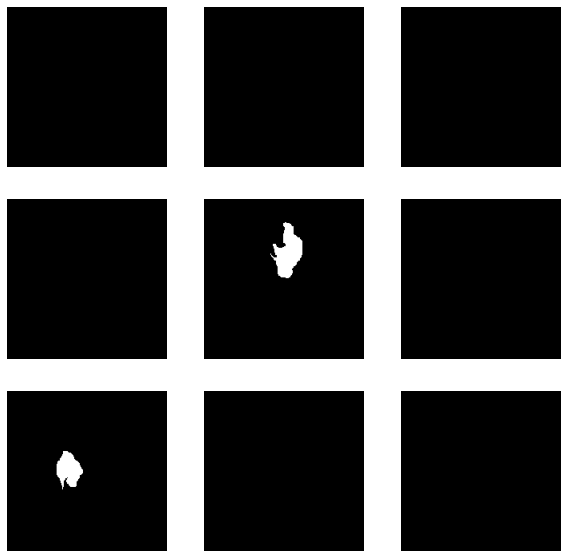

In [52]:
#true targets
im_size = (200,200)
plt.figure(figsize=(10,10))
for i in range(1,len(test_images_paths)+1):
  plot = plt.subplot(3,3,i)
  plt.axis("off")
  img = array_to_img(load_img(test_masks_paths[i-1],target_size=im_size))
  plt.imshow(array_to_img(img))

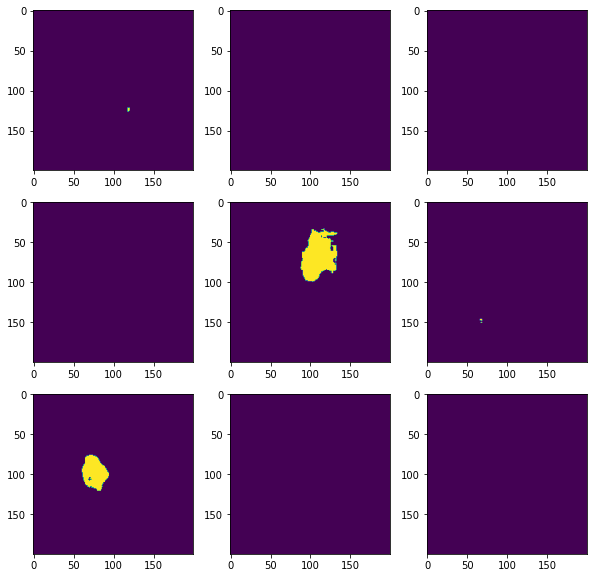

In [53]:
#Predictions
plt.figure(figsize=(10,10))
for i in range(9):
  mask = np.argmax(predictions[i], axis=-1)#build an array by extracting the max value from the channels build a single channel array
  mask *= 255
  plot = plt.subplot(3,3,i+1)
  plt.imshow(mask)

#Batch Normalization and Residual Connections